## Introduction

Sea ice extent has been measured with satellites since the late 1970s. A continuous record of the sea ice extent has been kept since the year 1978, when NASA launched the Scanning Multichannel Microwave Radiometer satellite[1]. We use data from [2] about the extent of the northern and southern sea ice measured daily from years 1978 - 2017. The aim of this project is to fit linear gaussian model to the measurements and predict the extent of the ice for the future years. We also infere the probability that the ice coverage is shrinking.



#### Description of the model:

We are fitting Gaussian linear model for the data. The gaussian linear model is a linear model in which the noise is expected vary according to a normal distribution. This is a reasonable choice of model to a problem where a main aim is to assess if the data values are incresing or deceasing and where the data is expected to contain noise due to multivariate, untractable causes. These are characteristics of our task. We hope to see if the sea ice is generally extending or contracting so a linear model is appropriate. And the climate generally is so chaotic or stochastic, affected by numerous varibles, such as currents of air and water, fluctuations of sun radiation and the ozone layer that the sea ice extent can reasonably be expected to vary according to a normal distribution.

#### Prior choices:

We use weakly informative prior for the parameters $\alpha$ and $\beta$. The prior of $\alpha$ is weakly informative being centered at the mean of the measured ice extent with variance of 100.

The prior for $\beta$ carries more information. Though we are not making an assumption whether the extent increases or decreases, we are assuming that the change of the extent is limited per year. We have zero mean and 0.5 variance.

#### Description and analysis of the used data

The data consists of two separate time series for the arctic (northern) and antarctic (southern) sea ica extent. We analyse the two time series in parallel in this project, performing the same data analysis methods for both. First we just load and plot the data:

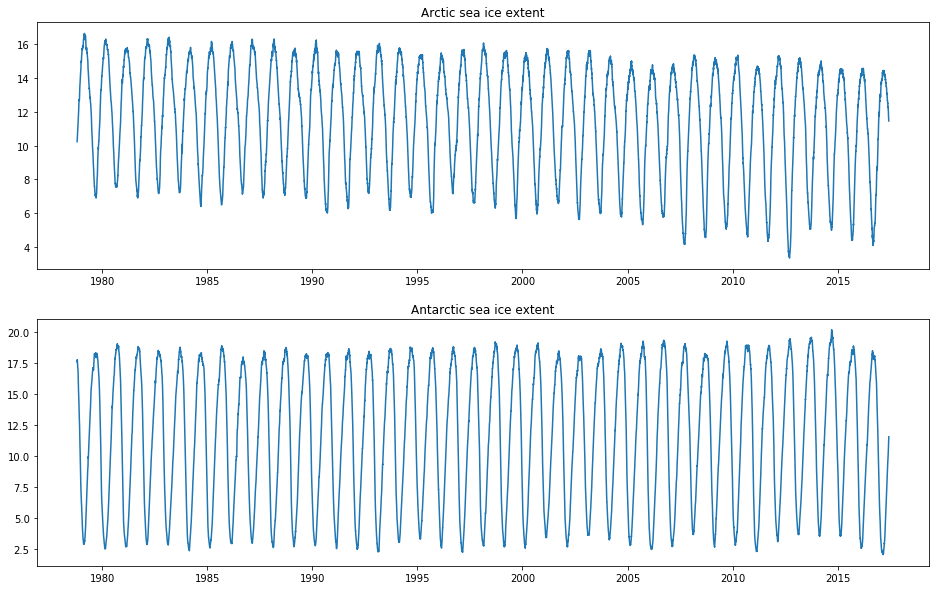

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import timedelta, date, datetime

# load the data
data = pd.read_csv('Data/seaice.csv').values

# the first half is for northern sea ice extent, the second for the southern
N = int(data.shape[0] / 2)
extent_north = data[:N, 3]
extent_south = data[N:, 3]

# parse the dates into a list of datetime.date objects
dates = [0]*N
for i in range(N):
    year = int(data[i, 0])
    month = int(data[i, 1])
    day = int(data[i, 2])
    dates[i] = date(year, month, day)
dates = sorted(dates)

# plot the data
plt.figure(1, figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(dates, extent_north)
plt.title('Arctic sea ice extent')
plt.subplot(2, 1, 2)
plt.title('Antarctic sea ice extent')
plt.plot(dates, extent_south)
plt.show()

We calculate the annual mean extent for each year to see the development of the extent:

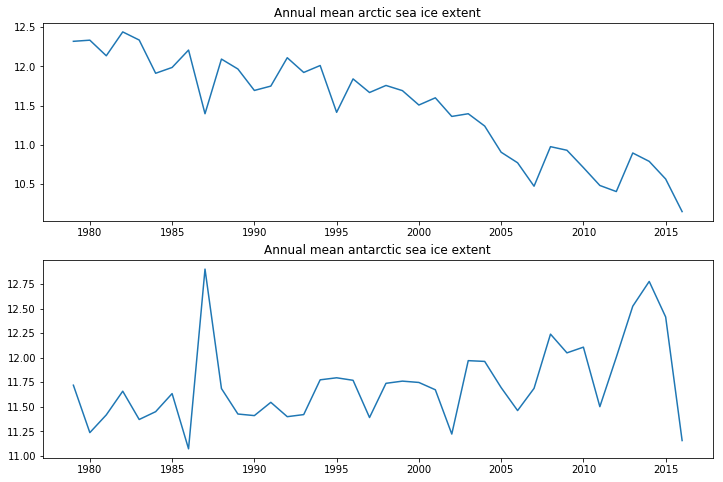

In [43]:
# calculate the average extent for each year
annual_means_north = [0]*40
annual_means_south = [0]*40
daycounts = [0]*40
current_year = 1978
i = 0
for year_index in range(40): # 1978 - 2017 = 40 years
    extent_sum_north = 0
    extent_sum_south = 0
    daycount = 0
    while(True):
        if(current_year == data[i, 0]):
            extent_sum_north += extent_north[i]
            extent_sum_south += extent_south[i]
            daycount += 1
            i += 1
        else:
            annual_means_north[year_index] = extent_sum_north / daycount
            annual_means_south[year_index] = extent_sum_south / daycount
            daycounts[year_index] = daycount
            current_year += 1
            break

# plot the average
plt.figure(2, figsize=(12, 8))
plt.subplot(2, 1, 1)
# omit first and last year because they are not whole
x = np.arange(1979, 2017)
y_north = np.array(annual_means_north[1:-1])
plt.plot(x, y_north) 
plt.title('Annual mean arctic sea ice extent')
plt.subplot(2, 1, 2)
plt.title('Annual mean antarctic sea ice extent')
y_south = annual_means_south[1:-1]
plt.plot(x, y_south)
plt.show()

There is a couple of properties of the data that we might have take into account when using the data. Firstly, the first and last year (1978 and 2017) are not whole years. 1978 starts in October and 2017 ends in June. This makes the average extents of these years not representative and not usable if we don't correct for the bias. The easiest option is to just omit these years, and this is what we chose to do (?). The second property is that the numbers of days is smaller for years before 1988. The extent is measured only every other day. However, this should not skew the data in any significant way.

In [44]:
# The number of measurements for each year
print(daycounts)

[34, 182, 183, 183, 182, 183, 183, 182, 183, 220, 354, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 158]


## The linear gaussian model

The Stan model [3]:

In [33]:
import pystan
# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_utility
with open('lin.stan') as file:
    print(file.read())

// Gaussian linear model with adjustable priors
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
  real pmualpha; // prior mean for alpha
  real psalpha;  // prior std for alpha
  real pmubeta;  // prior mean for beta
  real psbeta;   // prior std for beta
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  alpha ~ normal(pmualpha, psalpha);
  beta ~ normal(pmubeta, psbeta);
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}


In [56]:
y_north_mean = np.mean(y_north)
n_years = 38 # first and last year omitted
xpred = 2017 # prediction for the next year
data = dict(
    N = n_years,
    x = x,
    y = y_north,
    xpred = xpred,
    pmualpha = y_north_mean,    # centered
    psalpha  = 100,             # weakly informative prior
    pmubeta  = 0,               # a priori increase and decrese as likely
    psbeta   = (.5--.5)/2.0     # the extent of the ice doesn't decrease more than 0.5 per year
                    
)

if __name__ == '__main__':
    model = stan_utility.compile_model('lin.stan')
    fit = model.sampling(data, seed=1)
    print(fit)
    samples = fit.extract(permuted=True)

Using cached StanModel


Inference for Stan model: anon_model_1efff4822db8c0b931f9364e15aaaf89.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       116.83    0.24   7.51 102.41 111.84 116.85 121.93  131.5   1004    1.0
beta         -0.05  1.2e-4 3.8e-3  -0.06  -0.06  -0.05  -0.05  -0.05   1003    1.0
sigma         0.26  8.7e-4   0.03   0.21   0.23   0.25   0.28   0.33   1362    1.0
mu[1]        12.45  2.2e-3   0.08  12.29   12.4  12.45  12.51  12.62   1460    1.0
mu[2]         12.4  2.1e-3   0.08  12.25  12.35   12.4  12.46  12.56   1499    1.0
mu[3]        12.35  1.9e-3   0.08   12.2   12.3  12.35   12.4   12.5   1543    1.0
mu[4]         12.3  1.8e-3   0.07  12.16  12.25   12.3  12.35  12.44   1589    1.0
mu[5]        12.24  1.7e-3   0.07  12.11   12.2  12.24  12.29  12.38   1643    1.0
mu[6]        12.19  1.6e-3   0.07  12.06  12.14  12.19  12.24  1

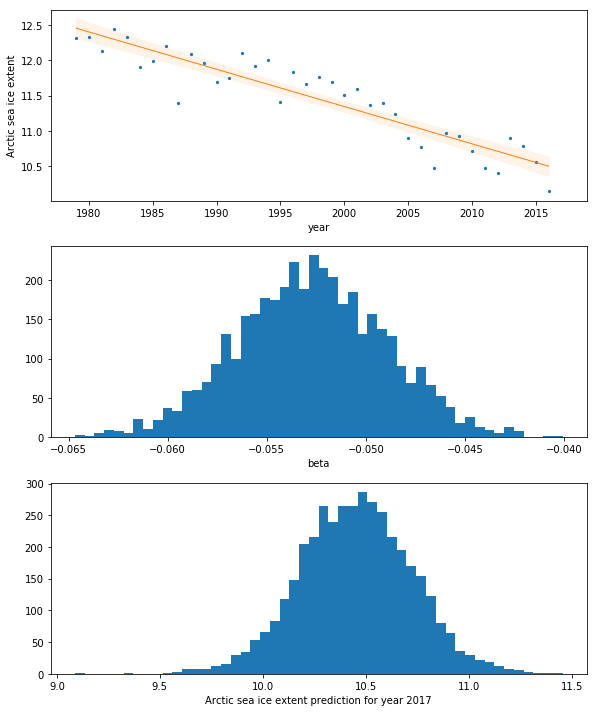

In [35]:
# make slightly wider figure of 3 plots
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 1.4  # width
figsize[1] *= 2.5  # height
fig, axes = plt.subplots(3, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
# lighten color_line
color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
# plot
ax = axes[0]
ax.fill_between(
    x,
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    color=color_shade
)
ax.plot(
    x,
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=1
)
ax.scatter(x, y_north, 5, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('Arctic sea ice extent')
ax.set_xlim((1977, 2019))

# plot 2: histogram
ax = axes[1]
ax.hist(samples['beta'], 50)
ax.set_xlabel('beta')

# plot 3: histogram
ax = axes[2]
ax.hist(samples['ypred'], 50)
ax.set_xlabel('Arctic sea ice extent prediction for year {}'.format(xpred))

# make figure compact
fig.tight_layout()
plt.show()

The same analysis for the southern ice:

In [36]:
y_south_mean = np.mean(y_south)
data2 = dict(
    N = n_years,
    x = x,
    y = y_south,
    xpred = xpred,
    pmualpha = y_south_mean,    # centered
    psalpha  = 100,             # weakly informative prior
    pmubeta  = 0,               # a priori increase and decrese as likely
    psbeta   = (.5--.5)/2.0     # the extent of the ice doesn't decrease more than 0.5 per year
                    
)
fit2 = model.sampling(data2, seed=1)
print(fit2)
samples2 = fit2.extract(permuted=True)

Inference for Stan model: anon_model_1efff4822db8c0b931f9364e15aaaf89.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       -20.49    0.36  12.17 -44.39 -28.44 -20.37 -12.12   3.68   1133    1.0
beta          0.02  1.8e-4 6.1e-3 4.0e-3   0.01   0.02   0.02   0.03   1133    1.0
sigma          0.4  1.3e-3   0.05   0.32   0.37    0.4   0.43   0.51   1329    1.0
mu[1]        11.43  3.5e-3   0.13  11.17  11.35  11.43  11.52  11.69   1418    1.0
mu[2]        11.45  3.3e-3   0.13  11.19  11.37  11.45  11.53   11.7   1445    1.0
mu[3]        11.46  3.2e-3   0.12  11.22  11.38  11.46  11.55   11.7   1476    1.0
mu[4]        11.48  3.0e-3   0.12  11.25   11.4  11.48  11.56  11.71   1513    1.0
mu[5]         11.5  2.8e-3   0.11  11.27  11.42   11.5  11.57  11.72   1556    1.0
mu[6]        11.51  2.7e-3   0.11   11.3  11.44  11.51  11.58  1

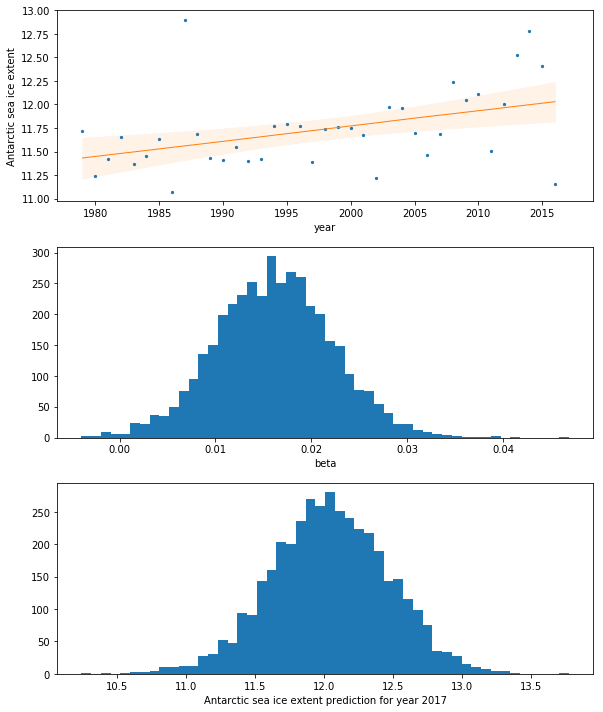

In [37]:
# make slightly wider figure of 3 plots
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 1.4  # width
figsize[1] *= 2.5  # height
fig, axes = plt.subplots(3, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
# lighten color_line
color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
# plot
ax = axes[0]
ax.fill_between(
    x,
    np.percentile(samples2['mu'], 5, axis=0),
    np.percentile(samples2['mu'], 95, axis=0),
    color=color_shade
)
ax.plot(
    x,
    np.percentile(samples2['mu'], 50, axis=0),
    color=color_line,
    linewidth=1
)
ax.scatter(x, y_south, 5, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('Antarctic sea ice extent')
ax.set_xlim((1977, 2019))

# plot 2: histogram
ax = axes[1]
ax.hist(samples2['beta'], 50)
ax.set_xlabel('beta')

# plot 3: histogram
ax = axes[2]
ax.hist(samples2['ypred'], 50)
ax.set_xlabel('Antarctic sea ice extent prediction for year {}'.format(xpred))

# make figure compact
fig.tight_layout()
plt.show()

#### Convergence diagnostics:

Rhat values for the $\alpha$ and $\beta$ are 1.0 for both time series, so the chains have converged and the results can be considered reliable.

We can calculate the probability that the extent is decreasing:

In [52]:
print("According to the model, the probability that the arctic ice extent is decreasing: ")
print('Pr(beta > 0) = {0:.5f}'.format(np.mean(samples['beta'] < 0)))

According to the model, the probability that the arctic ice extent is decreasing: 
Pr(beta > 0) = 1.00000


In [53]:
print("According to the model, the probability that the antarctic ice extent is decreasing: ")
print('Pr(beta > 0) = {0:.5f}'.format(np.mean(samples2['beta'] < 0)))

According to the model, the probability that the antarctic ice extent is decreasing: 
Pr(beta > 0) = 0.00475


Interestingly, the arctic sea ice extent is virtually certain to be decearsing but the antarctic is almost certainly increasing.

##### Model comparison (e.g. with loo)


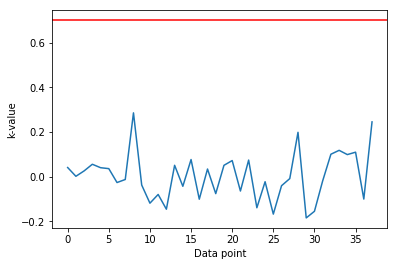

Estimated effective number of parameters:  3.1174593510408783
PSIS-LOO value:  -3.030707941114909


In [39]:
import psis
log_liks = samples["log_lik"]

loo, loos, ks = psis.psisloo(log_liks)
plt.plot(ks)
plt.axhline(y=0.7, color='r', linestyle='-')
plt.xlabel('Data point')
plt.ylabel('k-value')

plt.show()

#equations 7.5  and 7.15 from BDA 3rd edition, A.Vehtari et al
def p_eff(log_liks, loo):
    lppd = np.sum(np.log(np.mean(np.exp(log_liks))))
    return lppd - loo

print("Estimated effective number of parameters: ", p_eff(log_liks, loo))
print("PSIS-LOO value: ", loo)

    

The pareto k-shape values are all below 0.7 so the PSIS-LOO estimate can be considered reliable.

#### Discussion of problems and potetial improvements

We chose to use the mean extent of each year. Other option would have been to use the maximum or minimum extent of each year. This choice could have changed the results a little but probably not the general trend in the development of the sea ice extent.

## Conclusion

## References

[1] https://web.archive.org/web/20060930044535/http://podaac.jpl.nasa.gov:2031/SENSOR_DOCS/smmr.html

[2] https://www.kaggle.com/nsidcorg/daily-sea-ice-extent-data#seaice.csv

[3] https://github.com/avehtari/BDA_py_demos/tree/master/demos_pystan